# RTS and market indicators
https://www.moex.com/ru/index/stat/dailyhistory.aspx?code=RTSI


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import sqlalchemy as sa

import re
import numpy as np
import time

import locale
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

strURLBase=r'https://www.moex.com/ru/index/stat/dailyhistory.aspx?code=RTSI'

%run 'serv_pd.py'

eng_co=sa.create_engine('sqlite+pysqlite:///imoex.sqlite3') #, echo=True)

%matplotlib notebook
#import matplotlib.patches as mpatches

import seaborn as sns
sns.set_style('whitegrid')

now_date=datetime.now()
print(now_date.strftime('%Y%m%d'))

20181203


In [2]:
strURL_RTS_semi=r'https://www.moex.com/ru/index/stat/dailyhistorycsv.aspx?type=2&code=RTSI&day1=19950901&day2={endDay}&frmSessR=0'.format(endDay=now_date.strftime('%Y%m%d'))
strURL_RTS_comma=r'https://www.moex.com/ru/index/stat/dailyhistorycsv.aspx?code=RTSI&day1=19950901&day2={endDay}&frmSessR=0'.format(endDay=now_date.strftime('%Y%m%d'))

pdRTS=pd.read_csv(strURL_RTS_comma, encoding='cp1251', sep=',', index_col='Date')
pdRTS.astype(float)
pdRTS.index=pd.to_datetime(pdRTS.index, format='%d.%m.%Y')
pdRTS=pdRTS[['Open', 'Max', 'Min', 'Close', 'Trading Volume, USD', 'Market Capitalization, USD']]
print(pdRTS.shape)
print(pdRTS.head(10))

(5816, 6)
               Open      Max      Min    Close  Trading Volume, USD  \
Date                                                                  
2018-11-30  1139.27  1139.71  1119.50  1126.14          888879783.0   
2018-11-29  1123.14  1146.22  1123.14  1141.30          767528366.0   
2018-11-28  1099.75  1116.23  1096.28  1113.46          681309220.0   
2018-11-27  1085.12  1101.96  1085.12  1098.59          630535051.0   
2018-11-26  1115.68  1116.90  1072.69  1084.17          810008694.0   
2018-11-23  1136.94  1136.94  1110.36  1113.52          519467479.0   
2018-11-22  1131.27  1140.72  1127.02  1138.38          401307194.0   
2018-11-21  1113.72  1131.05  1112.38  1127.42          527136299.0   
2018-11-20  1139.97  1139.97  1107.43  1116.85          559660551.0   
2018-11-19  1134.05  1143.11  1131.08  1135.71          466516465.0   

            Market Capitalization, USD  
Date                                    
2018-11-30                1.523875e+11  
2018-11-29    

## Grouping and calculations

In [3]:
pdfg=pdRTS.groupby(pd.Grouper(freq='M'))
pdfRTS_monthly=pdfg[['Open', 'Min', 'Max', 'Close']].mean()
print(pdfRTS_monthly.tail(10))

pdfRTS_m_average=pdfRTS_monthly[['Min', 'Max']].mean(axis=1)
pdfRTS_m_average.name='RTS, monthly average'
print(pdfRTS_m_average.tail(10))

pdfRTS_volume=pdfg.agg({'Trading Volume, USD':'sum', 'Market Capitalization, USD':'mean'})
print(pdfRTS_volume.tail(10))

                   Open          Min          Max        Close
Date                                                          
2018-02-28  1259.306316  1249.796316  1270.540000  1260.088421
2018-03-31  1262.780476  1250.326190  1270.213333  1260.000952
2018-04-30  1162.565909  1142.054091  1172.299091  1155.866818
2018-05-31  1170.930476  1161.545238  1179.331429  1169.859048
2018-06-30  1138.412381  1130.163333  1147.196667  1137.927619
2018-07-31  1157.082273  1148.633636  1166.299545  1160.069545
2018-08-31  1091.724783  1078.505217  1099.426522  1088.789565
2018-09-30  1105.750000  1099.440500  1116.924000  1110.531500
2018-10-31  1144.008261  1132.458696  1153.866957  1142.158261
2018-11-30  1125.913333  1115.536667  1136.724762  1126.280952
Date
2018-02-28    1260.168158
2018-03-31    1260.269762
2018-04-30    1157.176591
2018-05-31    1170.438333
2018-06-30    1138.680000
2018-07-31    1157.466591
2018-08-31    1088.965870
2018-09-30    1108.182250
2018-10-31    1143.162826
2018-

## Plotting

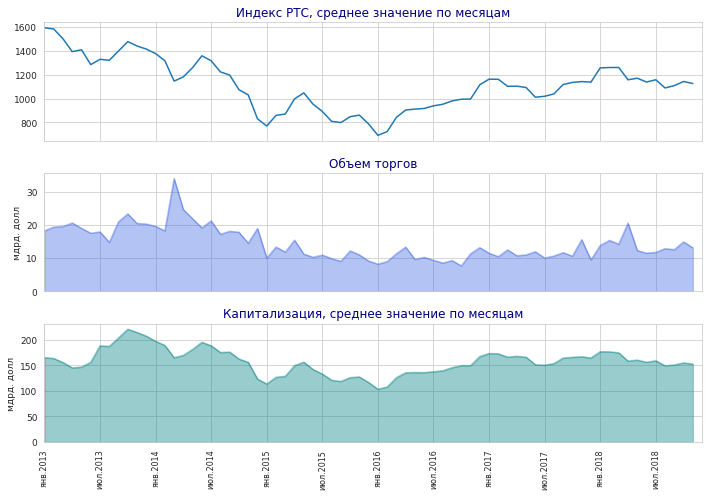

In [4]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

fig, (ax1, ax2, ax3)=plt.subplots(figsize=(10,7), nrows=3, ncols=1, sharex=True)

lBaseYear=2013

pdfRTS_m_average.loc[pdfRTS_m_average.index.year>=lBaseYear].plot.line(ax=ax1)

pdfRTS_vol=pdfRTS_volume.loc[pdfRTS_volume.index.year>=lBaseYear, ('Trading Volume, USD')]/1e9
pdfRTS_vol.plot.area(ax=ax2, color='royalblue', alpha=0.4)

pdfRTS_cap=pdfRTS_volume.loc[pdfRTS_volume.index.year>=lBaseYear, ('Market Capitalization, USD')]/1e9
pdfRTS_cap.plot.area(ax=ax3, xlim=(pd.Timestamp('{year}-01-01'.format(year=lBaseYear)), datetime.now()), color='teal', alpha=0.4)

ax1.set_title('Индекс РТС, среднее значение по месяцам', fontsize=12, color='navy')
ax2.set_title('Объем торгов', fontsize=12, color='navy')
ax3.set_title('Капитализация, среднее значение по месяцам', fontsize=12, color='navy')

ax3.set_xlabel('')
ax2.set_ylabel('мдрд. долл', fontsize=9)
ax3.set_ylabel('мдрд. долл', fontsize=9)

locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)
ax3.tick_params(axis='both', which='major', labelsize=9)

ax1.set_xticks(ticks=pdfRTS_cap.index.tolist()[::6])
ax2.set_xticks(ticks=pdfRTS_cap.index.tolist()[::6])
ax3.set_xticks(ticks=pdfRTS_cap.index.tolist()[::6])
ax3.set_xticklabels(pdfRTS_cap.index.strftime('%b.%Y')[::6], rotation=90, fontsize=8)

plt.tight_layout()
plt.show();
#plt.savefig(r'/home/egor/Изображения/RTS.png')

# Индекс МосБиржи IMOEX (ранее - Индекс ММВБ) 

In [5]:
from bs4 import BeautifulSoup
import sqlite3
import requests
import sqlalchemy as sa
import xml.etree.ElementTree as ET

#print(get_date_list(1987)) # check import serv_energy

#conn=sqlite3.connect('fuels.sqlite3')
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [6]:
#save RTS historical value, for some reasons

rts=RTSDataFrame(pdRTS)
rts.index_to_string()
rts.to_sql('RTS', con=eng_co, if_exists='upsert')

## Read IMOEX from https://www.moex.com/
https://www.moex.com/ru/index/IMOEX/archive/#/from=2000-01-01&till=2018-10-01&sort=TRADEDATE&order=desc

In [7]:
strIMOEX=r'https://www.moex.com/ru/index/IMOEX/archive/#/from={start_y}-{start_m:02d}-{start_d:02d}&till={end_y}-{end_m:02d}-{end_d:02d}&sort=TRADEDATE&order=desc'
strMOEX_xml=r'https://iss.moex.com/iss/history/engines/stock/markets/index/securities/IMOEX.xml?iss.only=history&iss.dp=comma&iss.df=%25Y-%25m-%25d&iss.tf=%25H%3A%25M%3A%25S&iss.dtf=%25Y.%25m.%25d%20%25H%3A%25M%3A%25S&iss.json=extended&callback=JSON_CALLBACK&from={start_y}-{start_m:02d}-{start_d:02d}&till={end_y}-{end_m:02d}-{end_d:02d}&limit={limit}&start={start}&sort_order=TRADEDATE&sort_order_desc={order}'

strIMOEX_base=strIMOEX.format(start_y=2000, start_m=1, start_d=1, 
                      end_y=datetime.now().year, end_m=datetime.now().month, end_d=datetime.now().day)

strIMOEX_xml_base=strMOEX_xml.format(start_y=2000, start_m=1, start_d=1, 
                    end_y=datetime.now().year, end_m=datetime.now().month, end_d=datetime.now().day, 
                    limit=100, start=0, order='asc')

lst_work_cols=['TRADEDATE', 'OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE', 'CAPITALIZATION']

def get_work_xml_string(start_y=2000, start_m=1, start_d=1, 
                    end_y=datetime.now().year, end_m=datetime.now().month, end_d=datetime.now().day, 
                    limit=100, start=0, order='asc'):
    return strMOEX_xml.format(start_y=start_y, start_m=start_m, start_d=start_d, 
                    end_y=end_y, end_m=end_m, end_d=end_d, limit=limit, start=start, order=order)

    

def get_part_imoex(strURL=strIMOEX_xml_base):
    sessMOEX=requests.session()
    wb_html=sessMOEX.get(strURL)
    
    root=ET.fromstring(wb_html.content)
    lst=[ {k:v for (k, v) in row.attrib.items() if k in lst_work_cols} for row in root.iter('row')]
    
    pdf=None
    try:
        if lst != []:
            pdf=pd.DataFrame(lst)[lst_work_cols]
    except:
        print(lst)

    return pdf
    
#pdfMOEX=get_part_imoex()
#print(datetime.strptime(pdfMOEX.tail(1)['TRADEDATE'].values[0], '%Y-%m-%d'))
#print(get_work_xml_string(limit=100, start=100))

def read_xml_table(start_date=datetime(2000, 1, 1), sorting='asc'):
    def to_float(x):
        try:
            return float(x.strip().replace(',', '.'))
        except:
            return np.nan

    moex=pd.DataFrame(columns=lst_work_cols)
    moex_ls=[]

    cur_dt=start_date
    tdd=timedelta(days=1)

    page_start=0

    while(cur_dt<=datetime.now()):
        moex_ls.append(get_part_imoex(strURL=get_work_xml_string(start=page_start, 
                                                                 order=sorting, start_y=start_date.year, 
                                                                 start_m=start_date.month, start_d=start_date.day)))
        try:
            cur_dt=datetime.strptime(moex_ls[-1].tail(1)['TRADEDATE'].values[0], '%Y-%m-%d')
        except AttributeError:
            break
        time.sleep(5)
        print(cur_dt)
        page_start+=100
    
    moex=RTSDataFrame(pd.concat(moex_ls).rename(columns={'TRADEDATE':'Date'}).set_index('Date'))
    moex.index_to_datetime(format='%Y-%m-%d')
    moex.index_to_string(format='%d-%m-%Y')

    moex=moex.applymap(lambda x: to_float(x))
    return moex

# for make whole table
#moex_whole = read_xml_table()
#moex_whole.to_sql('IMOEX', con=eng_co, if_exists='upsert')

#print(moex_whole.tail(10))

#for update table IMOEX
moex_update=read_xml_table(start_date=datetime.now()-timedelta(days=50), sorting='desc')
moex_update.to_sql('IMOEX', con=eng_co, if_exists='upsert')
print(moex_update.head(10))

2018-10-15 00:00:00
               OPEN    CLOSE     HIGH      LOW         VALUE  CAPITALIZATION
Date                                                                        
30-11-2018  2394.54  2392.50  2402.14  2378.74  5.948997e+10    1.019882e+13
29-11-2018  2387.45  2398.56  2410.49  2377.92  5.081414e+10    1.022465e+13
28-11-2018  2341.11  2381.12  2386.82  2341.11  4.589776e+10    1.015029e+13
27-11-2018  2311.17  2338.71  2345.01  2310.32  4.228564e+10    9.969535e+12
26-11-2018  2344.38  2308.50  2346.94  2284.30  5.433295e+10    9.840716e+12
23-11-2018  2368.39  2342.97  2368.39  2334.00  3.443264e+10    9.987695e+12
22-11-2018  2358.14  2369.53  2372.06  2348.04  2.631423e+10    1.010088e+13
21-11-2018  2339.29  2357.97  2362.28  2336.18  3.473090e+10    1.005160e+13
20-11-2018  2371.71  2341.60  2371.71  2323.95  3.696435e+10    9.981844e+12
19-11-2018  2375.21  2373.78  2391.72  2368.45  3.071717e+10    1.011899e+13


## Read IMOEX from DB

In [8]:
moex=RTSDataFrame(pd.read_sql('IMOEX', con=eng_co, index_col='Date'))
moex.index_to_datetime(format='%d-%m-%Y')
print(moex.sort_index())

               OPEN    CLOSE     HIGH      LOW         VALUE  CAPITALIZATION
Date                                                                        
2000-01-05      NaN   173.00      NaN      NaN           NaN             NaN
2000-01-06      NaN   186.26      NaN      NaN           NaN             NaN
2000-01-10      NaN   200.81      NaN      NaN           NaN             NaN
2000-01-11      NaN   199.57      NaN      NaN           NaN             NaN
2000-01-12      NaN   196.88      NaN      NaN           NaN             NaN
2000-01-13      NaN   210.05      NaN      NaN           NaN             NaN
2000-01-14      NaN   217.28      NaN      NaN           NaN             NaN
2000-01-17      NaN   219.73      NaN      NaN           NaN             NaN
2000-01-18      NaN   212.88      NaN      NaN           NaN             NaN
2000-01-19      NaN   200.66      NaN      NaN           NaN             NaN
2000-01-20      NaN   206.61      NaN      NaN           NaN             NaN

## Grouping and calc

In [9]:
lst_moex_work=['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE', 'CAPITALIZATION']

pdf_moexg=moex.groupby(pd.Grouper(freq='M'))
moex_monthly=pdf_moexg[lst_moex_work[:-2]].mean()
print(moex_monthly.tail(10))

moex_m_average=moex_monthly[['HIGH', 'LOW']].mean(axis=1)
moex_m_average.name='IMOEX, monthly average'
print(moex_m_average.tail(10))

moex_volume=pdf_moexg.agg({'VALUE':'sum', 'CAPITALIZATION':'mean'})
print(moex_volume.tail(10))

                   OPEN        CLOSE         HIGH          LOW
Date                                                          
2018-02-28  2272.337895  2273.786842  2288.386842  2259.286316
2018-03-31  2288.319524  2287.331429  2300.063333  2272.549524
2018-04-30  2235.738636  2236.146364  2258.189545  2212.944091
2018-05-31  2314.580000  2313.150000  2325.841429  2303.190000
2018-06-30  2268.326190  2267.380952  2281.641429  2256.253333
2018-07-31  2307.525909  2311.018182  2320.916818  2293.826364
2018-08-31  2294.316522  2295.886522  2308.217391  2276.970000
2018-09-30  2375.468000  2381.770000  2391.656000  2365.773500
2018-10-31  2391.274348  2387.103478  2407.960000  2369.760000
2018-11-30  2376.758571  2378.272381  2393.002381  2359.227619
Date
2018-02-28    2273.836579
2018-03-31    2286.306429
2018-04-30    2235.566818
2018-05-31    2314.515714
2018-06-30    2268.947381
2018-07-31    2307.371591
2018-08-31    2292.593696
2018-09-30    2378.714750
2018-10-31    2388.860000
2018-

In [10]:
moex_m_average.index=moex_m_average.index.map(lambda x: x.replace(day=1))
moex_volume.index=moex_volume.index.map(lambda x: x.replace(day=1))


pd.merge(moex_volume, moex_m_average.to_frame(), left_index=True, right_index=True).to_csv('imoex.csv', sep=';')

## Plotting IMOEX

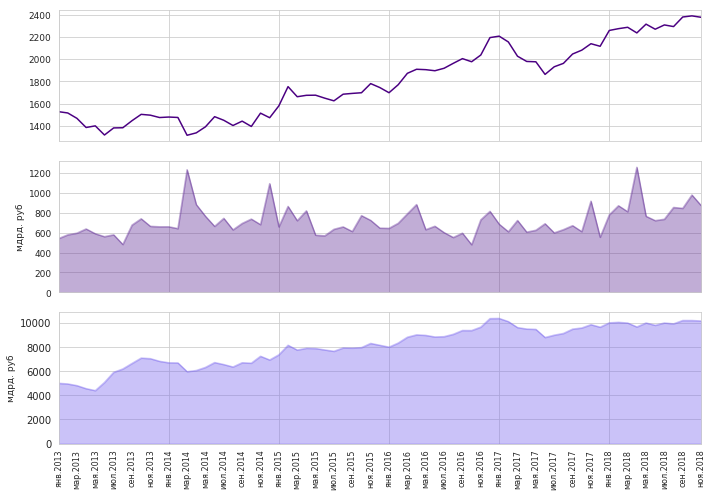

[516 528 540 552 564 576]


<Figure size 432x288 with 0 Axes>

In [12]:
#%matplotlib notebook
#import matplotlib.patches as mpatches

import matplotlib.dates as dates
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('whitegrid')

fig_mo, (ax_m1, ax_m2, ax_m3)=plt.subplots(figsize=(10,7), nrows=3, ncols=1, sharex=True)

lBaseYear_m=2013

xlim=(pd.Timestamp('{year}-01-01'.format(year=lBaseYear_m)), 
      pd.Timestamp('{year}-{month}-{day}'.format(year=datetime.now().year, month=datetime.now().month-1, day=30))) 
#print(xlim)
moex_m_average.loc[moex_m_average.index.year>=lBaseYear_m].plot.line(ax=ax_m1, color='indigo')

moex_vol=moex_volume.loc[moex_volume.index.year>=lBaseYear_m, ('VALUE')]/1e9
moex_vol.plot.area(ax=ax_m2, color='rebeccapurple', alpha=0.4)

moex_cap=moex_volume.loc[moex_volume.index.year>=lBaseYear_m, ('CAPITALIZATION')]/1e9
moex_cap.plot.area(ax=ax_m3, xlim=xlim, 
                   color='mediumslateblue', alpha=0.4)

#ax_m1.set_title('Индекс МосБиржи IMOEX, среднее значение по месяцам', fontsize=12, color='navy')
#ax_m2.set_title('Объем торгов', fontsize=12, color='navy')
#ax_m3.set_title('Капитализация, среднее значение по месяцам', fontsize=12, color='navy')

ax_m3.set_xlabel('')
ax_m2.set_ylabel('мдрд. руб', fontsize=9)
ax_m3.set_ylabel('мдрд. руб', fontsize=9)

locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

ax_m1.tick_params(axis='both', which='major', labelsize=9)
ax_m2.tick_params(axis='both', which='major', labelsize=9)
ax_m3.tick_params(axis='both', which='minor', labelsize=9)

ax_m1.set_xticks(ticks=moex_vol.index.tolist()[::12])
ax_m2.set_xticks(ticks=moex_vol.index.tolist()[::12])

ax_m3.set_xticks(ticks=moex_vol.index.tolist()[::2], minor=True)
ax_m3.set_xticklabels(moex_vol.index.strftime('%b.%Y')[::2], rotation=90, fontsize=8, minor=True)

#ax_m3.set_xticks(ticks=moex_vol.index.tolist()[::12], minor=False)

ax_m3.set_xticklabels(''*6, rotation=0, fontsize=8, 
                      minor=False)

#ax_m3.xaxis.set_tick_params(which='major', pad=50)

plt.tight_layout()
plt.show();
plt.savefig(r'/home/egor/Изображения/IMOEX.png')
print(ax_m3.get_xticks())

In [24]:
moex_data=moex_vol.reset_index().merge(moex_cap.reset_index(), on='Date').merge(moex_m_average.reset_index(), on='Date')
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
moex_data['Date']=moex_data['Date'].dt.strftime('%B %Y')
moex_data.to_csv('moex_last.csv', sep=';')
print(moex_data.tail(10))

             Date        VALUE  CAPITALIZATION  IMOEX, monthly average
61   февраля 2018   870.335546    10024.953514             2273.836579
62     марта 2018   810.190992     9968.712426             2286.306429
63    апреля 2018  1256.468004     9641.586489             2235.566818
64       мая 2018   764.273683     9973.605254             2314.515714
65      июня 2018   720.838879     9778.536584             2268.947381
66      июля 2018   734.637177     9972.584343             2307.371591
67   августа 2018   853.105291     9899.691373             2292.593696
68  сентября 2018   843.950442    10177.858188             2378.714750
69   октября 2018   978.180661    10175.811253             2388.860000
70    ноября 2018   872.458012    10138.163460             2376.115000


In [13]:
#from matplotlib.finance import candlestick_ohlc
import plotly.plotly as py
import plotly.offline as offline
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go

offline.init_notebook_mode(connected=True)

moex_cndl=pdfRTS_monthly.loc[moex_monthly.index.year>=lBaseYear_m] #moex_monthly.loc[moex_monthly.index.year>=lBaseYear_m]

#fig_cdl=FF.create_candlestick(moex_cndl['OPEN'], moex_cndl['HIGH'], moex_cndl['LOW'], moex_cndl['CLOSE'],  dates=moex_cndl.index)
fig_cdl=FF.create_candlestick(open=moex_cndl['Open'], high=moex_cndl['Max'], low=moex_cndl['Min'], close=moex_cndl['Close'],  dates=moex_cndl.index)
#add_line=go.Scatter(x=moex_cndl.index, y=moex_cndl['OPEN'], name='Open VALs', line=go.scatter.Line(color='black'))
#print(fig_cdl['data'])#.append([add_line])
offline.iplot(fig_cdl);#, filename='finance/aapl-candlestick', validate=False)

print(pdfRTS_monthly.columns.tolist())

/home/egor/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1506: UserWarning:

plotly.tools.FigureFactory.create_candlestick is deprecated. Use plotly.figure_factory.create_candlestick



['Open', 'Min', 'Max', 'Close']


In [14]:
print(moex_monthly.tail(10))

                   OPEN        CLOSE         HIGH          LOW
Date                                                          
2018-02-28  2272.337895  2273.786842  2288.386842  2259.286316
2018-03-31  2288.319524  2287.331429  2300.063333  2272.549524
2018-04-30  2235.738636  2236.146364  2258.189545  2212.944091
2018-05-31  2314.580000  2313.150000  2325.841429  2303.190000
2018-06-30  2268.326190  2267.380952  2281.641429  2256.253333
2018-07-31  2307.525909  2311.018182  2320.916818  2293.826364
2018-08-31  2294.316522  2295.886522  2308.217391  2276.970000
2018-09-30  2375.468000  2381.770000  2391.656000  2365.773500
2018-10-31  2391.274348  2387.103478  2407.960000  2369.760000
2018-11-30  2376.758571  2378.272381  2393.002381  2359.227619


In [275]:
plotly.__version__

'3.0.2'